# **Glioblastoma MRI Dicom format**

The Dataset contains the MRI Images in DICOM Format.

**DICOM** or **Digital Imaging and Communications in Medicine** is the standard for the communication and management of medical imaging information and related data

Here we have Data which have been recorded via 4 diferrent methods, listed below :
1. FLAIR - Fluid-attenuated inversion recovery.
2. T1w - T1-weighted
3. T1wCE - T1-weighted contrast enhanced 
4. T2w - T2 weighted image

Repetition Time (TR) is the amount of time between successive pulse sequences applied to the same slice. Time to Echo (TE) is the time between the delivery of the RF pulse and the receipt of the echo signal.

In general, T1- and T2-weighted images can be easily differentiated by looking the CSF. CSF is dark on T1-weighted imaging and bright on T2-weighted imaging.

A third commonly used sequence is the Fluid Attenuated Inversion Recovery (Flair). The Flair sequence is similar to a T2-weighted image except that the TE and TR times are very long.

# Most common MRI Sequences and their Approximate TR and TE times.

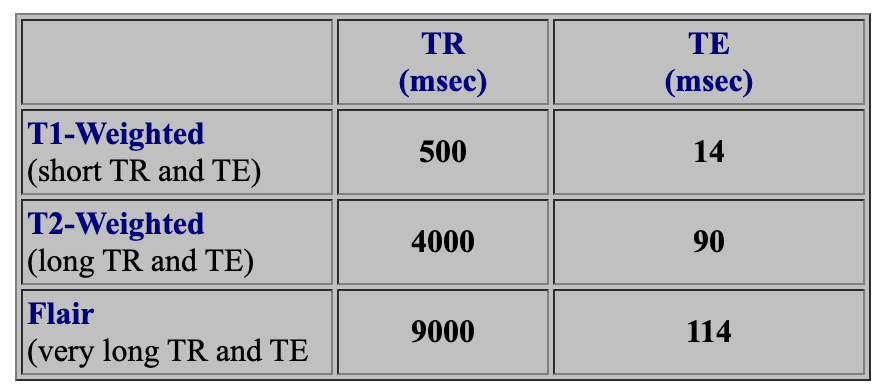

# Below is the Comparison of T1 vs. T2 vs. Flair (Brain)

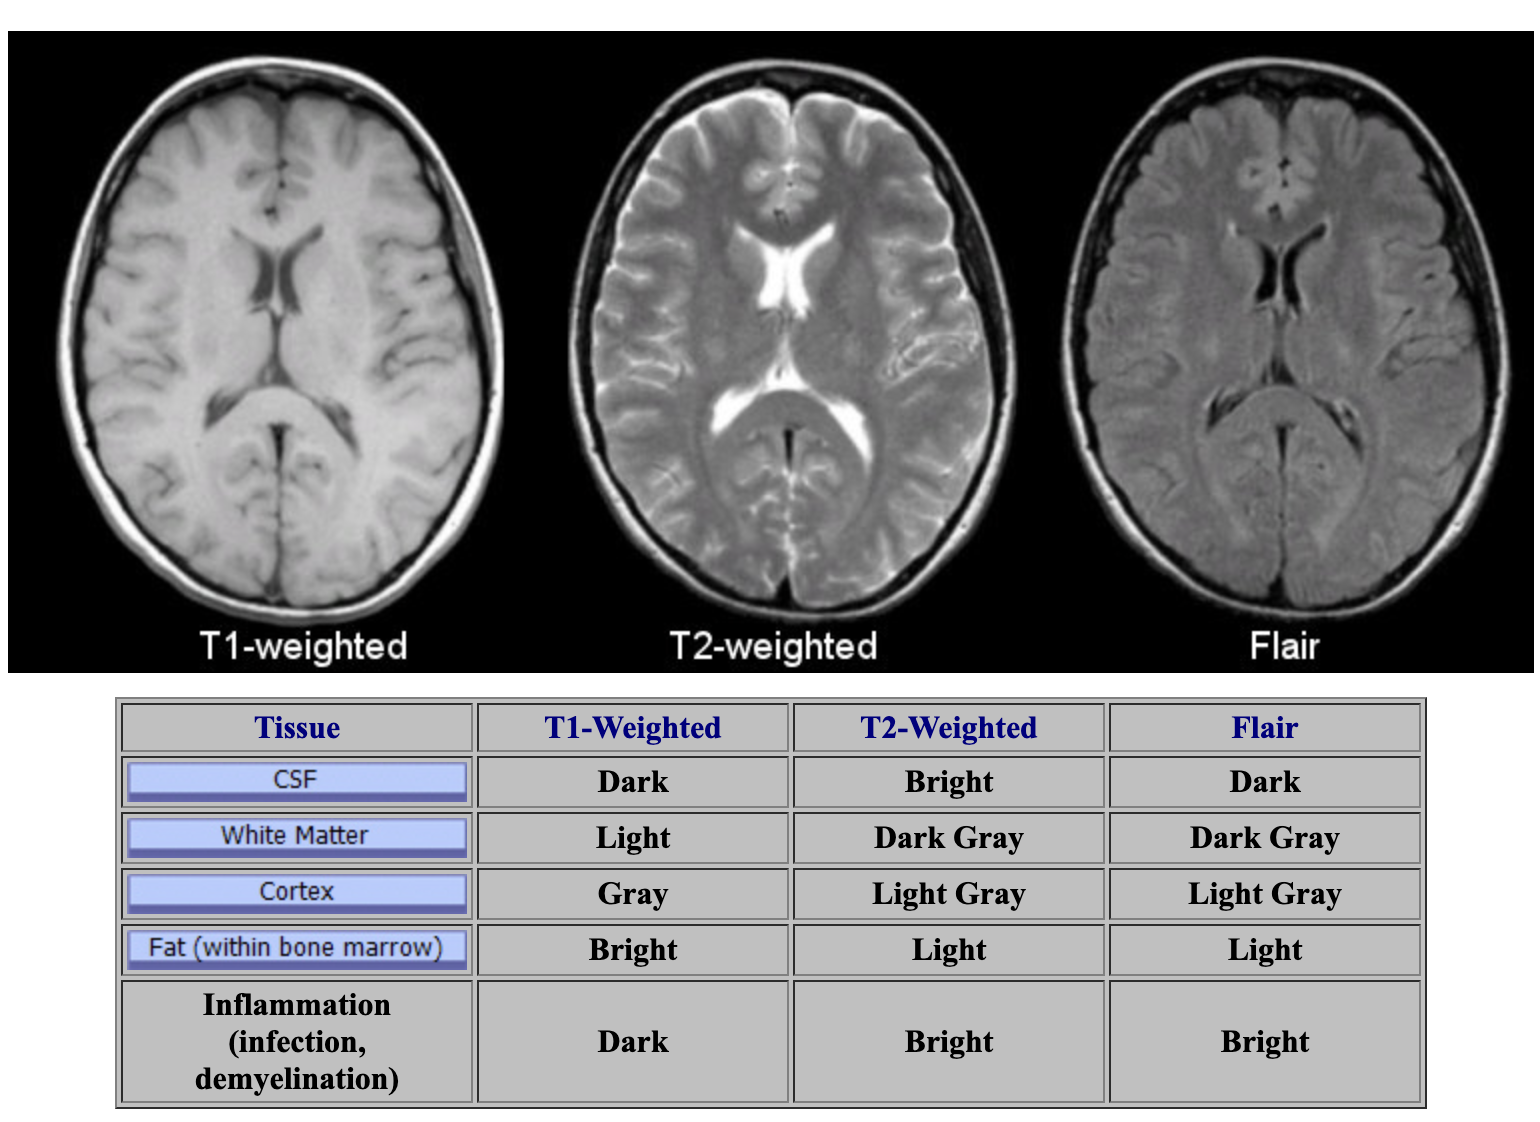

  

# Imports

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import os
import sys 
import json
import glob
import random
import collections
import time
import re
import math
import numpy as np
import pandas as pd
import cv2

# Specifying the location of the DICOM Image Dataset

In [4]:
train_data_directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000'
data_directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'
IMAGE_SIZE = 128
NUM_IMAGES = 64

# Defining the Parameters to dynamically access the location and Types of Dataset


In [5]:
num_imgs=NUM_IMAGES
img_size=IMAGE_SIZE
mri_type="T1w"
split="train"
rotate=0
scan_id = "00000"

# Printing the location of the dataset based on the input Parameters

In [6]:
f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"

'../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/T1w/*.dcm'

# This is a simple lambda function that returns the key if all is numerical otherwise just the numerical part. 


In [7]:
key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]

In [8]:
files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
print(files)

['../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/T1w/Image-1.dcm', '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/T1w/Image-2.dcm', '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/T1w/Image-3.dcm', '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/T1w/Image-4.dcm', '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/T1w/Image-5.dcm', '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/T1w/Image-6.dcm', '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/T1w/Image-7.dcm', '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/T1w/Image-8.dcm', '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/T1w/Image-9.dcm', '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/T1w/Image-10.dcm', '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000/T1w/

# Here we are choosing 64 images within p1 and p2 i.e my number of Images and stacking them in a numpy array taking their transpose 

In [9]:
middle = len(files)//2
num_imgs2 = num_imgs//2
p1 = max(0, middle - num_imgs2)
p2 = min(len(files), middle + num_imgs2)
print(len(files))
print(p1,p2)

33
0 33


# Defining the load_dicom_image and load_dicom_images_3d functions, more on this in the below sections

In [12]:
train_data_directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00000'
data_directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'
IMAGE_SIZE = 128
NUM_IMAGES = 64
def load_dicom_image(path, img_size=IMAGE_SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=IMAGE_SIZE, mri_type="T1w", split="train", rotate=0):
    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)



# Taking transpose of the 3D Image

Here we are Stacking the image from p1 to p2 using numby and then taking transpose of the same

In [38]:
img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T

In [39]:
print(img3d)

[[[-32768.         -32757.9362715  -32758.65920753 ... -32755.76418969
   -32768.         -32745.43285124]
  [-32768.         -32757.9362715  -32758.65920753 ... -32755.76418969
   -32768.         -32745.43285124]
  [-32768.         -32757.9362715  -32758.65920753 ... -32755.76418969
   -32768.         -32745.43285124]
  ...
  [-32768.         -32757.9362715  -32758.65920753 ... -32755.76418969
   -32768.         -32745.43285124]
  [-32768.         -32757.9362715  -32758.65920753 ... -32755.76418969
   -32768.         -32745.43285124]
  [-32768.         -32757.9362715  -32758.65920753 ... -32755.76418969
   -32768.         -32745.43285124]]

 [[-32768.         -32757.9362715  -32758.65920753 ... -32755.76418969
   -32768.         -32745.43285124]
  [-32768.         -32757.9362715  -32758.65920753 ... -32755.76418969
   -32768.         -32745.43285124]
  [-32768.         -32757.9362715  -32758.65920753 ... -32755.76418969
   -32768.         -32745.43285124]
  ...
  [-32768.         -327

# 

# Shaping the image3d shape returns a tuple with each index having the number of corresponding elements.

Taking Transpose of the image formats support in CHW encoding format

In [40]:
img3d.T.shape
print(img3d.T.shape)

(33, 128, 128)


# Verifying the Transpose


In [41]:
print(img3d.shape,img3d.shape[-1])

(128, 128, 33) 33


# 


# Checking if the number of images that we stacked is less then the Number of images of Threshold, which we defined as 64 in our case

In [42]:
img3d.shape[-1] < num_imgs

True

# If the sampled images are less than 64 i.e the number of images then we will put black array of pixels of the same size to take the number of images to 64

We do this as we expect our model to accept teh standard format of the data

In [43]:
if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)

In [46]:
print(np.min(img3d),np.max(img3d))

0.0 1.0


# The below operation is basically the scaling of pixels where we subtract the minimum value and divide by the maximum value.

In [45]:
if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)

# Now you can notice the number of images have become 64 when we added black pixels

In [47]:
img3d.shape

(128, 128, 64)

In [48]:
np.expand_dims(img3d,0).T.shape

(64, 128, 128, 1)

# Plotting the image for 64 Datasets

(1, 128, 128, 64)
0.0 1.0 0.388693263925815 0.310656788413254
Dimension of the CT scan is: (128, 128, 64)


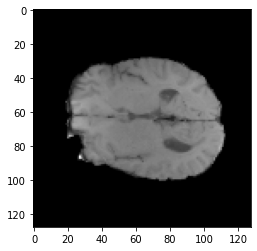

In [49]:
a = load_dicom_images_3d("00003")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))
image = a[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 15]), cmap="gray")

# Generate the training Dataset

# Analysing the CSV Provided in the dataset and mapping with the BraTS2ID with MGMT_Value

In [52]:
df_train_labels = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
df_train_labels.head()

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


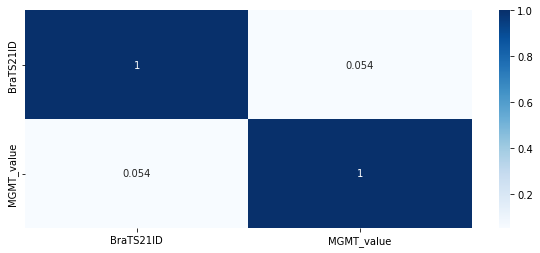

In [53]:
import seaborn as sns

df_train_labels.corr()
plt.figure(figsize=(10,4))
sns.heatmap(df_train_labels.corr(),annot=True,cmap='Blues')
plt.show()

 # Checking the number of samples in the the data Directory provided

In [50]:
train_data_directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/'
print(min(os.listdir(train_data_directory)), max(os.listdir(train_data_directory)))

00000 01010


# Lets not take all 1010 samples for training as this will led to a lot of memory and time consumption hence lets take only 200 samples out of these all. You can use below line of code for all. 

In [51]:
total_training_scans = np.array([load_dicom_images_3d(a, split = 'train') for a in os.listdir(train_data_directory)])

In [54]:
count = 0
list_train_files = []
for file in os.listdir(train_data_directory):
    if count<200:
        list_train_files.append(file)
        count = count+1

## Taking first 200 samples for observation

In [55]:
total_training_scans = np.array([load_dicom_images_3d(a, split = 'train') for a in list_train_files])

### Checking if the 200 samples were created in the dataset

The we are printing a random image from the fisrt 200 samples which we created, here for example we are taking 30 and plotting the same

(200, 1, 128, 128, 64)
200
Dimension of the CT scan is: (1, 128, 128, 64)


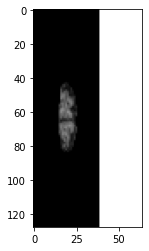

In [64]:
print(total_training_scans.shape)
print(len(total_training_scans))
image = total_training_scans[30]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 25]), cmap="gray")

# Split data in the ratio 70-30 for training and validation.


In [66]:
x_train = np.array([train.T for train in total_training_scans[:140]])
x_val = np.array([train.T for train in total_training_scans[140:]])


# Taking the MGMT Value and putting it in the list

In [67]:
total_training_labels = df_train_labels["MGMT_value"].to_list()

# This will be used as training and validating for our model.

In [68]:
y_train = total_training_labels[:140]
y_val = total_training_labels[140:]

#  Here we are taking the first 60 Dicom image and plotting below

# 6 rows and 10 columns for 60 slices of the CT scan.

Please note you can change dataset and MRI Image Type by calling the function: load_dicom_images_3d("00002",mri_type="FLAIR")

Here we have taken 00002 as BraTS2ID and MRI Type as FLAIR


(1, 128, 128, 64)
0.0 1.0 0.05406515444930317 0.0
Dimension of the CT scan is: (128, 128, 64)
(128, 128, 64)
(128, 128)


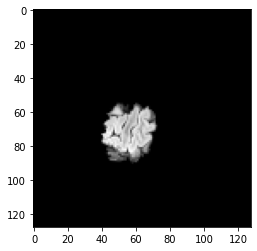

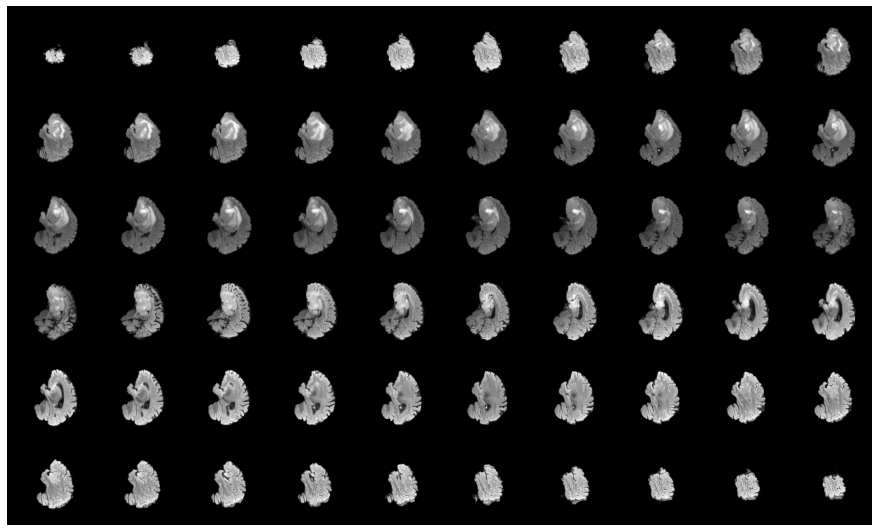

In [74]:
def plot_slices(num_rows, num_columns, width, height, data):
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

a = load_dicom_images_3d("00002",mri_type="FLAIR")
print()
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))
image = a[0]
print("Dimension of the CT scan is:", image.shape)
print(image.shape)
print(np.squeeze(image[:, :, 60]).shape)
plt.imshow(np.squeeze(image[:, :, 60]), cmap="gray")
plot_slices(6, 10, 128, 128, image[:, :, :60])

# Here in the above image you may notice that the beginning portion is small while it gradually increases and again comes to the smaller shape, its an interesting point to note, When we scan the brain, we begin with the left or the right most part which eventually wil cover the small portion of the brain, while moving on we get the larger brain image and then again the smaller portion as we move leftmost or rightmost.